# Multilayer Perceptum (MLP) <a name="multilayer"></a>


We are going to use **Multilayer Perceptron (MLP)** because it is a flexible neural network architecture. MLPs are great for solving **classification problems**

For this model we will define the model architecture and the training strategy consisting in:
- **Number of layers**
- **Number of neurons of each layer**
- **Choice of the activation functions**
- **Optimizer** 
- **Learning hyperparameters** (e.g., learning rate, mini-batch size, number of epochs, etc.)
- **Regularization techniques to adopt** (e.g., early stopping, weight regularization, dropout)

The network works by processing data through **multiple layers**, with each layer learning to capture different features of the input data.

### Model architecture definition and Training Strategy <a name="archi-train"></a>

For the architecture of our MLP model we need, as mentioned above, the number of layers, neurons, and choose the activation functions such as relu, softmax and Tanh for example.

We used **dictionaries** to organize and store different options for **hyperparameters**. This allows us to easily experiment with different configurations and manage the settings efficiently.

To optimize our model, we decided to do a grid search to **update and select the best hyperparameter combination in the first iteration**. This means that in the beginning, we test several combinations of hyperparameters to find the one that performs best. By doing this, we can quickly narrow down the best model for our task, improving the **accuracy** of the predictions.

Additionally, we will use the **ADAM** optimizer, which is a popular choice for training neural networks due to its adaptive learning rate and efficient performance.
We also implemented **early stopping** to prevent overfitting by monitoring the model's performance and halting training when it stops improving.

In this way, the process of **testing and updating** in the first iteration helps us fine-tune the model efficiently, and **selecting the best combination** ensures we are using the most effective settings for our dataset.

The following table defines the possible combinations of hyperparameters we tested:

| <span style="color: #C70039;">**Hyperparameter**</span> | <span style="color: #C70039;">**Options**</span>        |
|-----------------------------------------------------|-------------------------------------------------------|
| <span style="color: #00bfae;">**Hidden Units**</span> | [128, 64, 32], [256, 128, 64], [256, 128, 64, 32]                |
| <span style="color: #00bfae;">**Activation Functions**</span> | reLU, sigmoid, tanh                             |
| <span style="color: #00bfae;">**Dropout Rate**</span> | 0.2, 0.3, 0.4                                         |
| <span style="color: #00bfae;">**Batch Size**</span>   | 32, 64                                               |
| <span style="color: #00bfae;">**Epochs**</span>       | 20, 50                                                 |
| <span style="color: #00bfae;">**Regularizations**</span>       | None, L1 (Lasso), L2 (Ridge)                                            |
| <span style="color: #00bfae;">**Learning Rate**</span> | 0.001, 0.0001                                     |


<span style="color: #C70039;">**Note:**</span>
- <span style="color: #00bfae;">**Hidden Units**</span> consists in the number of layers and the number of each neurons of each layer, for example in this case [256, 128, 64], it defines 3 layers with 256, 128 and 64 neurons, respectively.


### MLP Implementation  <a name="multilayer"></a>
[[go back to the top]](#multilayer)

Here we start the MLP implementation with the provided explanation of our workflow.

##### Imports

In [50]:
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
from pathos.multiprocessing import Pool
import random 
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

##### Class MLP
[[go back to the topic]](#mlp-implementation)

Defines a flexible Multi-Layer Perceptron (MLP) with configurable layers, dropout, activation functions, and optional **l1** or **l2** regularization. Includes a method to compute regularization loss for better generalization.

In [2]:
class MLP(tf.keras.Model):
    def __init__(self, input_dim, output_dim, hidden_units, dropout_rate, activations, regularization_type=None, regularization_value=0.01):
        super(MLP, self).__init__()
        self.hidden_layers = []
        self.regularization_type = regularization_type
        self.regularization_value = regularization_value

        for units, activation in zip(hidden_units, activations):
            self.hidden_layers.append(
                tf.keras.layers.Dense(units, activation=activation)
            )
            self.hidden_layers.append(tf.keras.layers.Dropout(dropout_rate))
        
        self.output_layer = tf.keras.layers.Dense(output_dim, activation='softmax')  


    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)
    
    def compute_regularization_loss(self):
        regularization_loss = 0.0
        if self.regularization_type:
            for layer in self.hidden_layers:
                if isinstance(layer, tf.keras.layers.Dense):
                    weights = layer.kernel
                    if self.regularization_type == 'l1':
                        regularization_loss += tf.reduce_sum(tf.abs(weights)) * self.regularization_value
                    elif self.regularization_type == 'l2':
                        regularization_loss += tf.reduce_sum(tf.square(weights)) * self.regularization_value
        return regularization_loss

##### Hyperparameter Configuration Generator and Load Fold Data
[[go back to the topic]](#mlp-implementation)

Generates all possible combinations of hyperparameter configurations from a dictionary of options using Cartesian product. Loads features and labels from a specific fold's dataset file, separating the Label column from the feature matrix for training and evaluation purposes.

In [3]:
def generate_configs(configurations):
    keys, values = zip(*configurations.items())
    return [dict(zip(keys, v)) for v in itertools.product(*values)]

def load_fold_data(fold_number, files):
    data = pd.read_csv(files[fold_number])
    labels = data.pop('Label').values
    features = data.values
    return features, labels

##### Train, Evaluate, and Cross-Validate MLP
[[go back to the topic]](#mlp-implementation)

This code trains and evaluates the MLP model using a specified configuration and implements single-fold cross-validation. The training process includes a custom loss function that integrates a regularization term to improve generalization, uses early stopping to prevent overfitting, and calculates validation accuracy on the held-out fold.

In [4]:
def train_evaluate_model(config, X_train, y_train, X_val, y_val):
    model = MLP(
        input_dim=X_train.shape[1],
        output_dim=10,
        hidden_units=config['hidden_units'],
        dropout_rate=config['dropout_rate'],
        activations=config['activations'],
        regularization_type=config.get('regularization_type', None),
        regularization_value=config.get('regularization_value', 0.01)
    )
    
    def loss_with_regularization(y_true, y_pred):
        base_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        regularization_loss = model.compute_regularization_loss()
        return base_loss + regularization_loss

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss=loss_with_regularization,
        metrics=['accuracy']
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        callbacks=[early_stopping],
        verbose=0
    )

    return history.history


# Cross-validation, just one iteration (1 fold)
def cross_validate_model(config, files):
    # Only the first fold for validation
    fold_number = 0
    X_val, y_val = load_fold_data(fold_number, files)
    X_train, y_train = [], []
    
    # Training with other folds
    for i in range(len(files)):
        if i != fold_number:
            X_temp, y_temp = load_fold_data(i, files)
            X_train.append(X_temp)
            y_train.append(y_temp)
    
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    # Train and evaluate for this fold
    accuracy = train_evaluate_model(config, X_train, y_train, X_val, y_val)
    return accuracy  

##### Parallel Evaluation and Activation Combination Generation
[[go back to the topic]](#mlp-implementation)

This code enables parallel evaluation of model configurations by performing cross-validation and logging the results (configuration and accuracy). It also generates random activation function combinations for different hidden layer structures, creating varied configurations for testing and optimization. The results are saved in a log file for later analysis.

In [5]:
def evaluate_config_parallel(args):
    config, files = args
    accuracy = cross_validate_model(config, files)
    
    with open("results_log.txt", "a") as f:
        f.write(f"Configuration: {config} | Accuracy: {accuracy}\n")
    
    return config, accuracy

def generate_activation_combinations(hidden_units_list, activations_list = ['relu', 'sigmoid', 'tanh'], num_combinations=1):
    activation_combinations = []
    for hidden_units in hidden_units_list:
        layers = len(hidden_units)
        for _ in range(num_combinations):
            random_combination = [random.choice(activations_list) for _ in range(layers)]
            activation_combinations.append((hidden_units, random_combination))  
    return activation_combinations

##### Generate and Select Hyperparameter Configurations
[[go back to the topic]](#mlp-implementation)

This code generates combinations of hidden units, activation functions, and other hyperparameters such as dropout rate, batch size, epochs, and regularization settings. It then creates a list of all possible configurations for model training.

In [6]:
hidden_units_list = [[128, 64, 32], [256, 128, 64], [256, 128, 64, 32]]

activation_combinations = generate_activation_combinations(hidden_units_list)

hidden_units = [combo[0] for combo in activation_combinations]
activations = [combo[1] for combo in activation_combinations]

configurations = {
    "hidden_units": hidden_units,  
    "activations": activations,    
    "dropout_rate": [0.2, 0.3, 0.4],
    "batch_size": [32,64],
    "epochs": [20,50],
    "learning_rate": [0.001, 0.0001],
    "regularization_type": [None, 'l1', 'l2'],
    "regularization_value": [0.01, 0.001],
}

files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1,11)] 

all_configs = generate_configs(configurations)

### Parallel Evaluation and Best Configuration Selection
[[go back to the topic]](#mlp-implementation)

This code evaluates different model configurations in parallel using multiple workers. It first removes any existing result files (**results_log.txt**) to ensure a clean start. Then, it uses a multiprocessing pool with 8 workers to evaluate each configuration in **all_configs**. The results are logged and the best configuration, based on accuracy, is selected and printed.

In [ ]:
if os.path.exists("results_log.txt"):
    os.remove("results_log.txt")
num_workers = 8
with Pool(num_workers) as pool:
    results = pool.map(evaluate_config_parallel, [(config, files) for config in all_configs])

# Find the best configuration
best_config, best_accuracy = max(results, key=lambda x: x[1])
print(f"Best configuration: {best_config}, Best accuracy: {best_accuracy}")

Best configuration: {'hidden_units': [256, 128, 64], 'activations': ['relu', 'relu', 'relu'], 'dropout_rate': 0.3, 'batch_size': 64, 'epochs': 20, 'learning_rate': 0.0001, 'regularization_type': None, 'regularization_value': 0.01}, Best accuracy: 0.7216494679450989


Based on the optimal hyperparameter configuration identified: **'hidden_units':** [256, 128, 64], **'activations':** ['relu', 'relu', 'relu'], **'dropout_rate':** 0.3, **'batch_size':** 64, **'epochs':** 20, **'learning_rate':** 0.0001, **'regularization_type':** None, **'regularization_value':** 0.01** with a **best accuracy** of 0.7216, we will now implement data augmentation techniques to evaluate and enhance model robustness.

### Data Augmentation
[[go back to the topic]](#multilayer)


We are applying data augmentation to enhance the diversity of our dataset. Techniques include **adding noise**, **scaling feature values**, **simulating 
pitch shifts**, and **equalizing frequency ranges**.

These transformations aim to improve model **generalization** and **robustness**.

In [43]:
def add_noise(features, noise_level=0.01):
    noise = np.random.normal(0, noise_level, features.shape)
    return features + noise

def scale_features(features, scale_range=(0.9, 1.1)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1], features.shape)
    return features * scale_factor

def pitch_shift(features, shift_range=(-2, 2)):
    """
    Aplica uma modificação simulada nos MFCCs para simular pitch shifting.
    shift_range define o número de semitons.
    """
    shift_value = np.random.uniform(*shift_range)  
    shifted_features = features.copy()
    if shifted_features.shape[1] >= 13:  
        shifted_features[:, :13] += shift_value
    return shifted_features

def equalize(features, eq_factor=1.5):
    """
    Simula equalização amplificando as frequências médias.
    Amplificação arbitrária nas colunas centrais.
    """
    features = np.copy(features)
    mid_point = features.shape[1] // 2
    if mid_point - 5 >= 0 and mid_point + 5 < features.shape[1]:
        features[:, mid_point - 5:mid_point + 5] *= eq_factor
    return features

def augment_data(features, labels, augmentation_count=2):
    augmented_features = []
    augmented_labels = []
    for _ in range(augmentation_count):
        augmented_features.append(add_noise(features))
        augmented_features.append(scale_features(features))
        augmented_features.append(pitch_shift(features))
        augmented_features.append(equalize(features))
        augmented_labels.extend(labels)
        augmented_labels.extend(labels)
        augmented_labels.extend(labels)
        augmented_labels.extend(labels)
    return np.vstack(augmented_features), np.array(augmented_labels)


Now we are going to apply data augmentation to audio feature datasets. For each file, we augment the features.

In [ ]:
def augment_csv_files(files, output_dir="augmented_datasets"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for file in files:
        data = pd.read_csv(file)
        labels = data.pop('Label').values
        features = data.values
        
        # Perform data augmentation
        aug_features, aug_labels = augment_data(features, labels, augmentation_count=2)
        
        # Combine original data with augmented data
        combined_features = np.vstack((features, aug_features))
        combined_labels = np.hstack((labels, aug_labels))
        
        # Save the new CSV
        combined_data = pd.DataFrame(combined_features, columns=data.columns)
        combined_data['Label'] = combined_labels
        output_file = os.path.join(output_dir, os.path.basename(file))
        combined_data.to_csv(output_file, index=False)
        print(f"Augmented data saved to {output_file}")

files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]
augment_csv_files(files)


Augmented data saved to augmented_datasets/urbansounds_features_fold1.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold2.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold3.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold4.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold5.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold6.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold7.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold8.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold9.csv
Augmented data saved to augmented_datasets/urbansounds_features_fold10.csv


### 10-fold cross-validation on the augmented datasets


**Cross-Validation Schema**:
   - **1 Fold** for **Testing**: Original data only.
   - **1 Fold** for **Validation**: Original data only.
   - **8 Folds** for **Training**: Augmented data.



. Train the model using the augmented training set and the best configuration (`best_config`).

. Evaluate the model on the test set after training.


In [14]:
# Best configuration já definida
best_config = {
    'hidden_units': [256, 128, 64],
    'activations': ['relu', 'relu', 'relu'],
    'dropout_rate': 0.3,
    'batch_size': 64,
    'epochs': 20,
    'learning_rate': 0.0001,
    'regularization_type': None,
    'regularization_value': 0.01
}

def load_augmented_data(fold_number, augmented_files):
    return load_fold_data(fold_number, augmented_files)

def load_fold_data(fold_number, files):
    data = pd.read_csv(files[fold_number - 1]) 
    if data.empty:
        print(f"Erro: O arquivo {files[fold_number - 1]} está vazio ou não foi carregado corretamente.")
    labels = data.pop('Label').values
    features = data.values
    return features, labels

In [19]:

def train_evaluate_model(config, X_train, y_train, X_val, y_val):
    model = MLP(
        input_dim=X_train.shape[1],
        output_dim=10,
        hidden_units=config['hidden_units'],
        dropout_rate=config['dropout_rate'],
        activations=config['activations'],
        regularization_type=config.get('regularization_type', None),
        regularization_value=config.get('regularization_value', 0.01)
    )
    
    def loss_with_regularization(y_true, y_pred):
        base_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        regularization_loss = model.compute_regularization_loss()
        return base_loss + regularization_loss

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss=loss_with_regularization,
        metrics=['accuracy']
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        callbacks=[early_stopping],
        verbose=0
    )
    return history  

def evaluate_on_test(config, X_train, y_train, X_test, y_test):
    model = MLP(
        input_dim=X_train.shape[1],
        output_dim=10,
        hidden_units=config['hidden_units'],
        dropout_rate=config['dropout_rate'],
        activations=config['activations'],
        regularization_type=config.get('regularization_type', None),
        regularization_value=config.get('regularization_value', 0.01)
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    model.fit(X_train, y_train, batch_size=config['batch_size'], epochs=config['epochs'], verbose=0)
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    return test_loss, test_accuracy


import numpy as np

import numpy as np

def cross_validate_with_test_and_plot(files, augmented_files, best_config):
    folds = list(range(1, 11))
    all_histories = []
    all_accuracies = []

    for test_fold in folds:
        print(f"Analyzing Test Fold {test_fold}")

        train_val_folds = [fold for fold in folds if fold != test_fold]
        fold_accuracies = []

        for val_fold in train_val_folds:
        
            train_folds = [fold for fold in train_val_folds if fold != val_fold]

            # Load training data
            X_train, y_train = [], []
            for fold in train_folds:
                X_temp, y_temp = load_augmented_data(fold, augmented_files)
                X_train.append(X_temp)
                y_train.append(y_temp)
            X_train = np.concatenate(X_train, axis=0)
            y_train = np.concatenate(y_train, axis=0)

            # Load validation and test data
            X_val, y_val = load_augmented_data(val_fold, augmented_files)
            X_test, y_test = load_fold_data(test_fold, files)

            # Train and evaluate on validation fold
            history = train_evaluate_model(best_config, X_train, y_train, X_val, y_val)
            all_histories.append((test_fold, val_fold, history))  # Guardar histórico para análise futura

            # Avaliação no conjunto de teste
            _, val_accuracy = evaluate_on_test(best_config, X_train, y_train, X_val, y_val)
            fold_accuracies.append(val_accuracy)

            # Atualização da métrica a cada Test-Validation fold
            mean_accuracy = np.mean(fold_accuracies)
        
            print(f"Test Fold: {test_fold}, Validation Fold: {val_fold} -> Accuracy: {val_accuracy:.4f}")

        # Métricas após todos os Validation folds
        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        all_accuracies.extend(fold_accuracies)

        print(f"fold {test_fold} Mean Accuracy: {mean_accuracy:.4f}, fold {test_fold} Std Dev: {std_accuracy:.4f}")

        # Plot individual fold history
        plot_test_fold_summary(test_fold, history)

    # Cálculo final de métricas
    final_mean_accuracy = np.mean(all_accuracies)
    final_std_accuracy = np.std(all_accuracies)
    print(f"Final Mean Accuracy: {final_mean_accuracy:.4f}, Final Std Dev: {final_std_accuracy:.4f}")

    return all_histories

def plot_test_fold_summary(test_fold, history):
    
    epochs = range(1, len(history.history['accuracy']) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Gráfico de acurácia
    axs[0].plot(epochs, history.history['accuracy'], label='Train Accuracy', color='blue')
    axs[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axs[0].set_title(f'Test Fold {test_fold} - Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].grid(alpha=0.3)

    # Gráfico de perda
    axs[1].plot(epochs, history.history['loss'], label='Train Loss', color='green')
    axs[1].plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')
    axs[1].set_title(f'Test Fold {test_fold} - Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:


files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]
augmented_files=[f'augmented_datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]
# Executando a validação cruzada
cross_validate_with_test_and_plot(files, augmented_files, best_config)



### 10-fold cross-validation on the original datasets

The schema is the same as the previous one but this time we only use the original data: 

   - **1 Fold** for **Testing**: Original data.
   - **1 Fold** for **Validation**: Original data.
   - **8 Folds** for **Training**: Original data.

Analyzing Test Fold 1
Test Fold: 1, Validation Fold: 2 -> Accuracy: 0.5619
Test Fold: 1, Validation Fold: 3 -> Accuracy: 0.5524
Test Fold: 1, Validation Fold: 4 -> Accuracy: 0.5859
Test Fold: 1, Validation Fold: 5 -> Accuracy: 0.5972
Test Fold: 1, Validation Fold: 6 -> Accuracy: 0.5188
Test Fold: 1, Validation Fold: 7 -> Accuracy: 0.5072
Test Fold: 1, Validation Fold: 8 -> Accuracy: 0.6514
Test Fold: 1, Validation Fold: 9 -> Accuracy: 0.5699
Test Fold: 1, Validation Fold: 10 -> Accuracy: 0.6141
fold 1 Mean Accuracy: 0.5732, fold 1 Std Dev: 0.0427


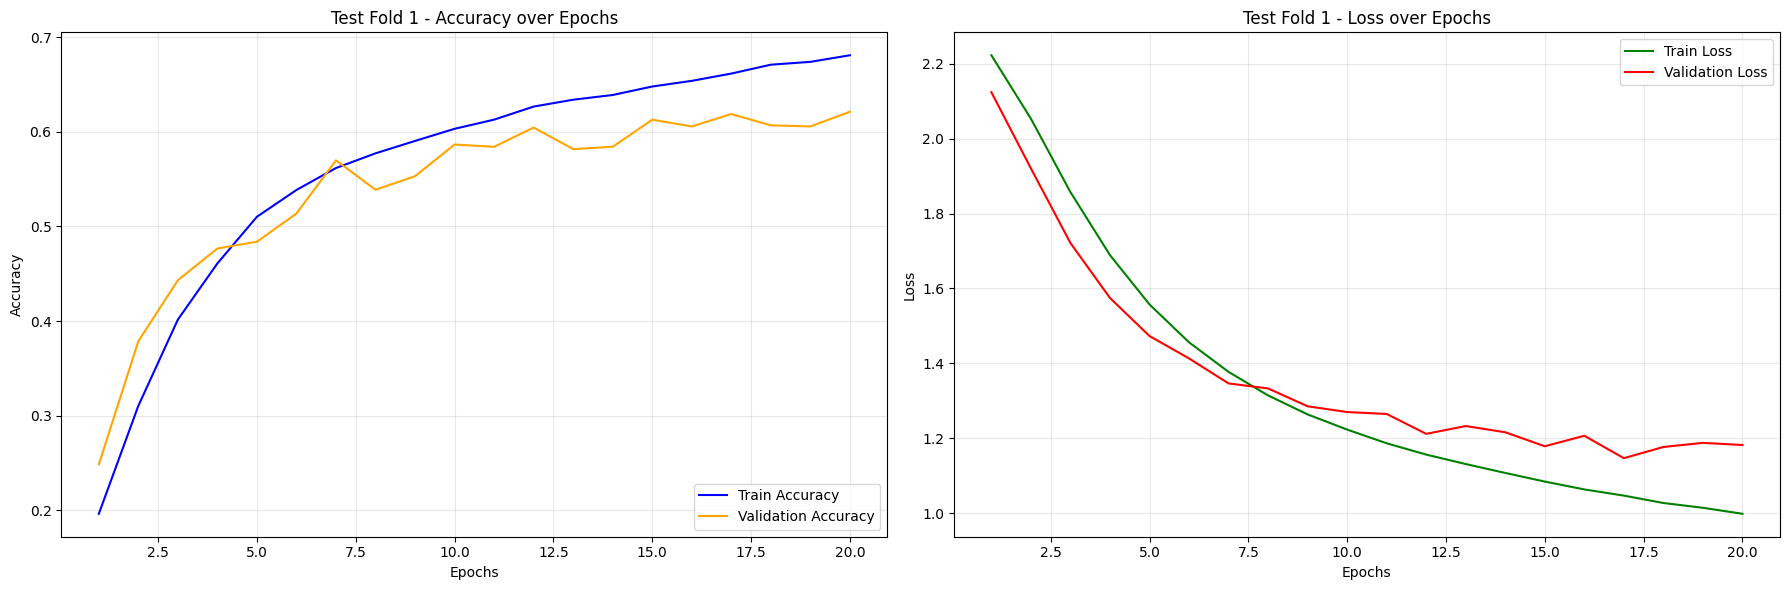

Analyzing Test Fold 2
Test Fold: 2, Validation Fold: 1 -> Accuracy: 0.6816
Test Fold: 2, Validation Fold: 3 -> Accuracy: 0.5546
Test Fold: 2, Validation Fold: 4 -> Accuracy: 0.5778
Test Fold: 2, Validation Fold: 5 -> Accuracy: 0.6261
Test Fold: 2, Validation Fold: 6 -> Accuracy: 0.5115
Test Fold: 2, Validation Fold: 7 -> Accuracy: 0.5549
Test Fold: 2, Validation Fold: 8 -> Accuracy: 0.6414
Test Fold: 2, Validation Fold: 9 -> Accuracy: 0.5270
Test Fold: 2, Validation Fold: 10 -> Accuracy: 0.6260
fold 2 Mean Accuracy: 0.5890, fold 2 Std Dev: 0.0541


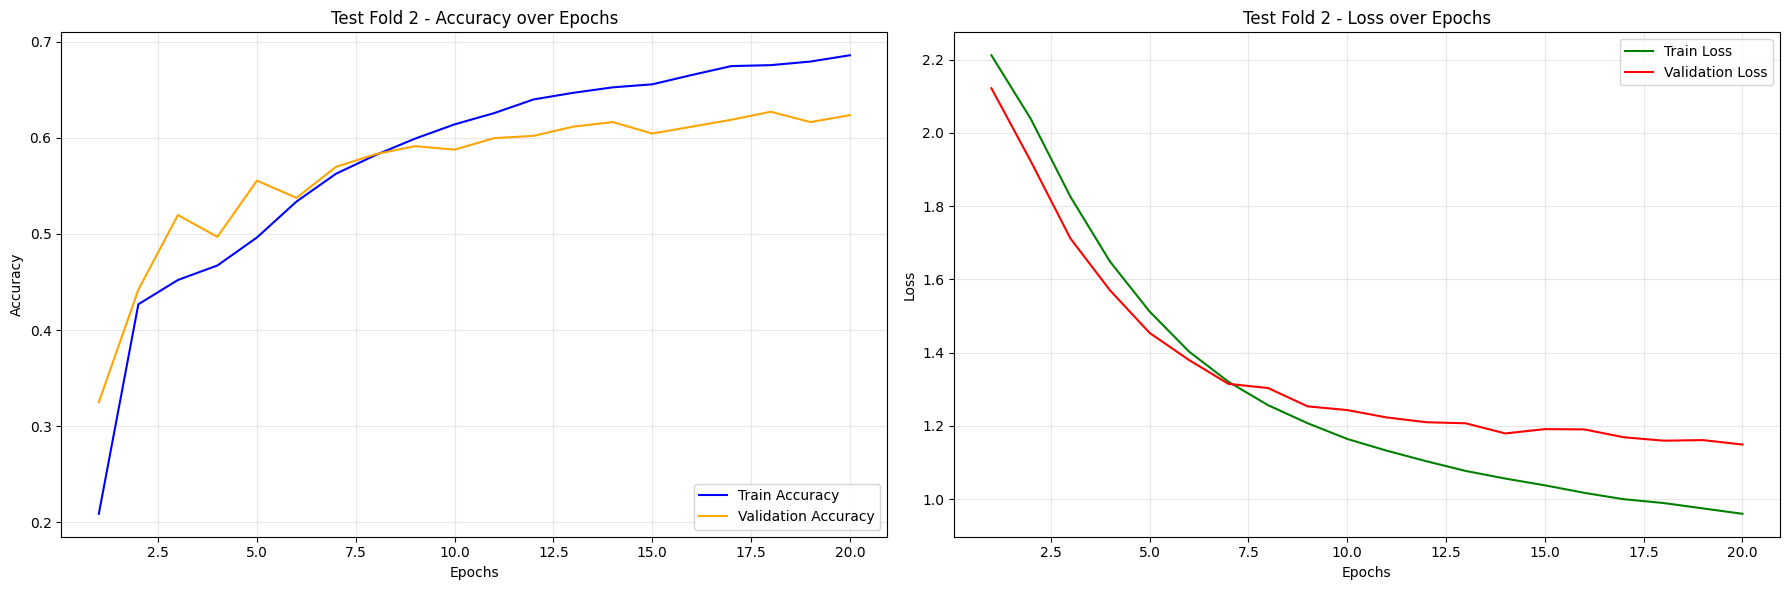

Analyzing Test Fold 3
Test Fold: 3, Validation Fold: 1 -> Accuracy: 0.6541
Test Fold: 3, Validation Fold: 2 -> Accuracy: 0.5495
Test Fold: 3, Validation Fold: 4 -> Accuracy: 0.6010
Test Fold: 3, Validation Fold: 5 -> Accuracy: 0.6132
Test Fold: 3, Validation Fold: 6 -> Accuracy: 0.5492
Test Fold: 3, Validation Fold: 7 -> Accuracy: 0.5609
Test Fold: 3, Validation Fold: 8 -> Accuracy: 0.5633
Test Fold: 3, Validation Fold: 9 -> Accuracy: 0.5392
Test Fold: 3, Validation Fold: 10 -> Accuracy: 0.6010
fold 3 Mean Accuracy: 0.5813, fold 3 Std Dev: 0.0360


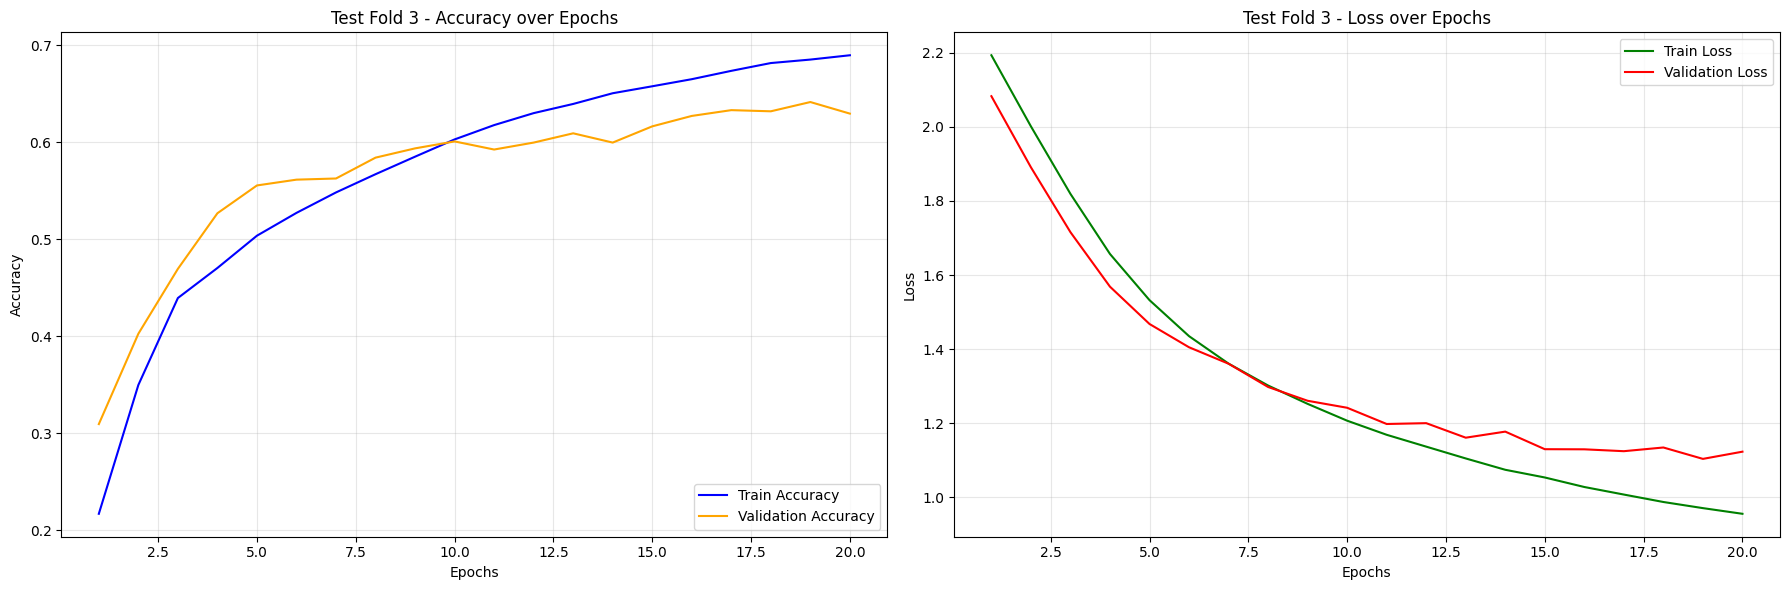

Analyzing Test Fold 4
Test Fold: 4, Validation Fold: 1 -> Accuracy: 0.6678
Test Fold: 4, Validation Fold: 2 -> Accuracy: 0.5360
Test Fold: 4, Validation Fold: 3 -> Accuracy: 0.5719
Test Fold: 4, Validation Fold: 5 -> Accuracy: 0.5983
Test Fold: 4, Validation Fold: 6 -> Accuracy: 0.5577
Test Fold: 4, Validation Fold: 7 -> Accuracy: 0.5656
Test Fold: 4, Validation Fold: 8 -> Accuracy: 0.6303
Test Fold: 4, Validation Fold: 9 -> Accuracy: 0.5919
Test Fold: 4, Validation Fold: 10 -> Accuracy: 0.6416
fold 4 Mean Accuracy: 0.5957, fold 4 Std Dev: 0.0408


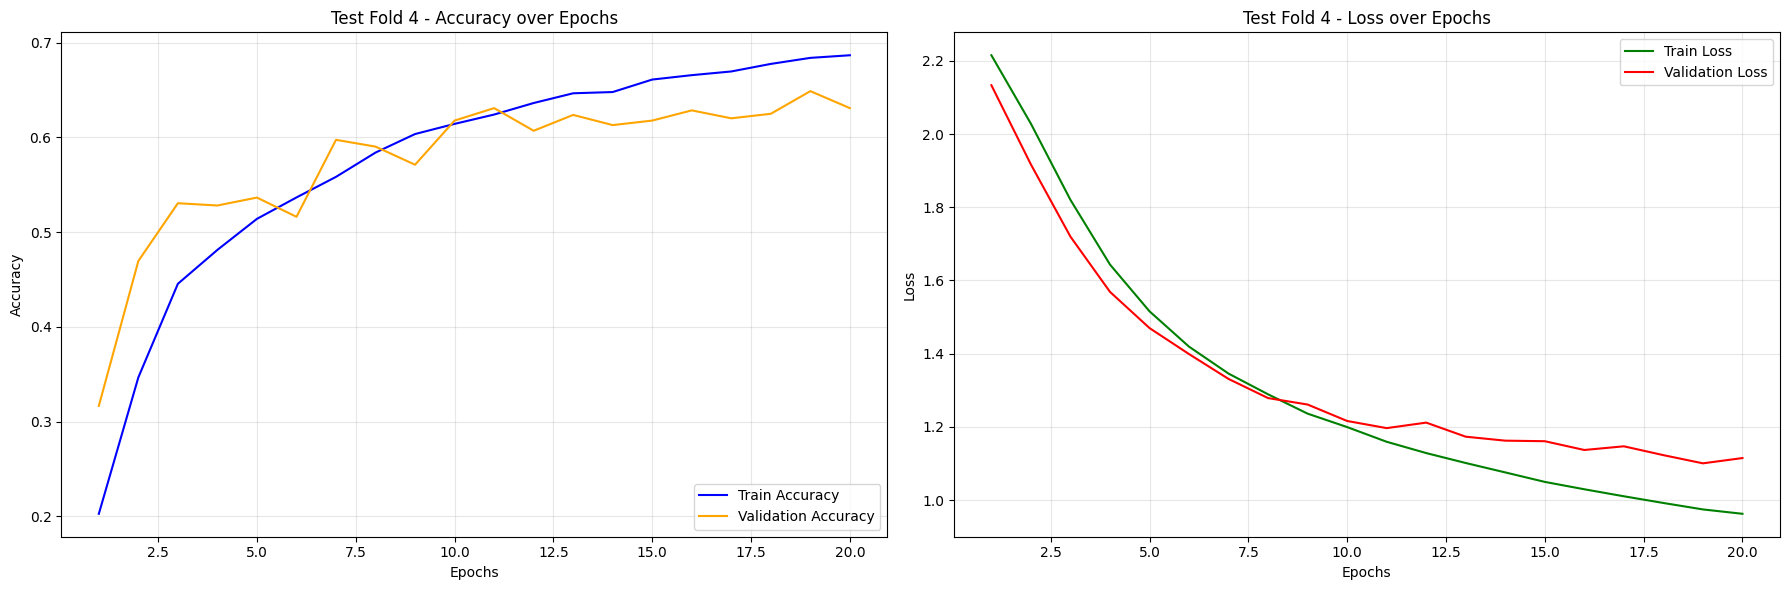

Analyzing Test Fold 5
Test Fold: 5, Validation Fold: 1 -> Accuracy: 0.6747
Test Fold: 5, Validation Fold: 2 -> Accuracy: 0.5439
Test Fold: 5, Validation Fold: 3 -> Accuracy: 0.5816
Test Fold: 5, Validation Fold: 4 -> Accuracy: 0.5545
Test Fold: 5, Validation Fold: 6 -> Accuracy: 0.5784
Test Fold: 5, Validation Fold: 7 -> Accuracy: 0.5334
Test Fold: 5, Validation Fold: 8 -> Accuracy: 0.5533
Test Fold: 5, Validation Fold: 9 -> Accuracy: 0.5515
Test Fold: 5, Validation Fold: 10 -> Accuracy: 0.5986
fold 5 Mean Accuracy: 0.5744, fold 5 Std Dev: 0.0404


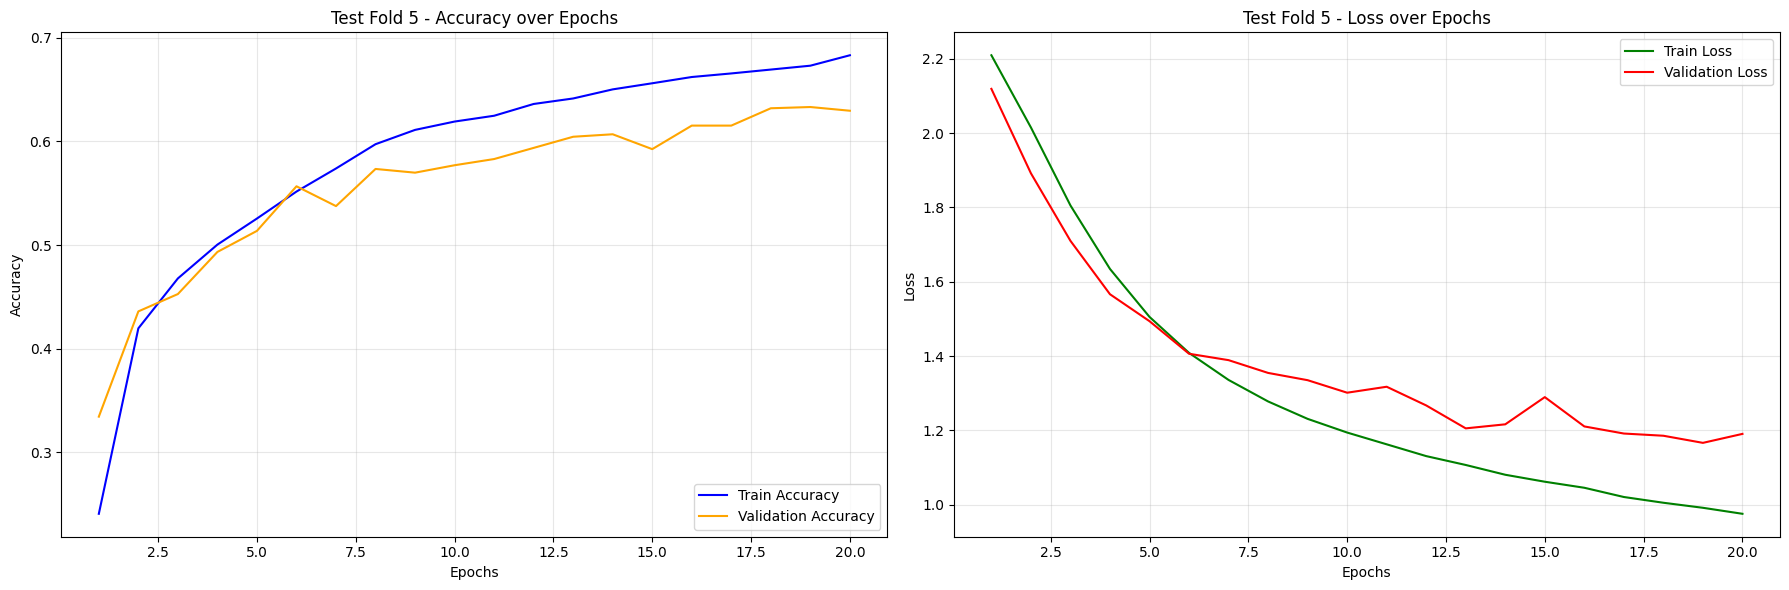

Analyzing Test Fold 6
Test Fold: 6, Validation Fold: 1 -> Accuracy: 0.6105
Test Fold: 6, Validation Fold: 2 -> Accuracy: 0.5788
Test Fold: 6, Validation Fold: 3 -> Accuracy: 0.6043
Test Fold: 6, Validation Fold: 4 -> Accuracy: 0.5980
Test Fold: 6, Validation Fold: 5 -> Accuracy: 0.6378
Test Fold: 6, Validation Fold: 7 -> Accuracy: 0.5537
Test Fold: 6, Validation Fold: 8 -> Accuracy: 0.6439
Test Fold: 6, Validation Fold: 9 -> Accuracy: 0.5833
Test Fold: 6, Validation Fold: 10 -> Accuracy: 0.6225
fold 6 Mean Accuracy: 0.6037, fold 6 Std Dev: 0.0274


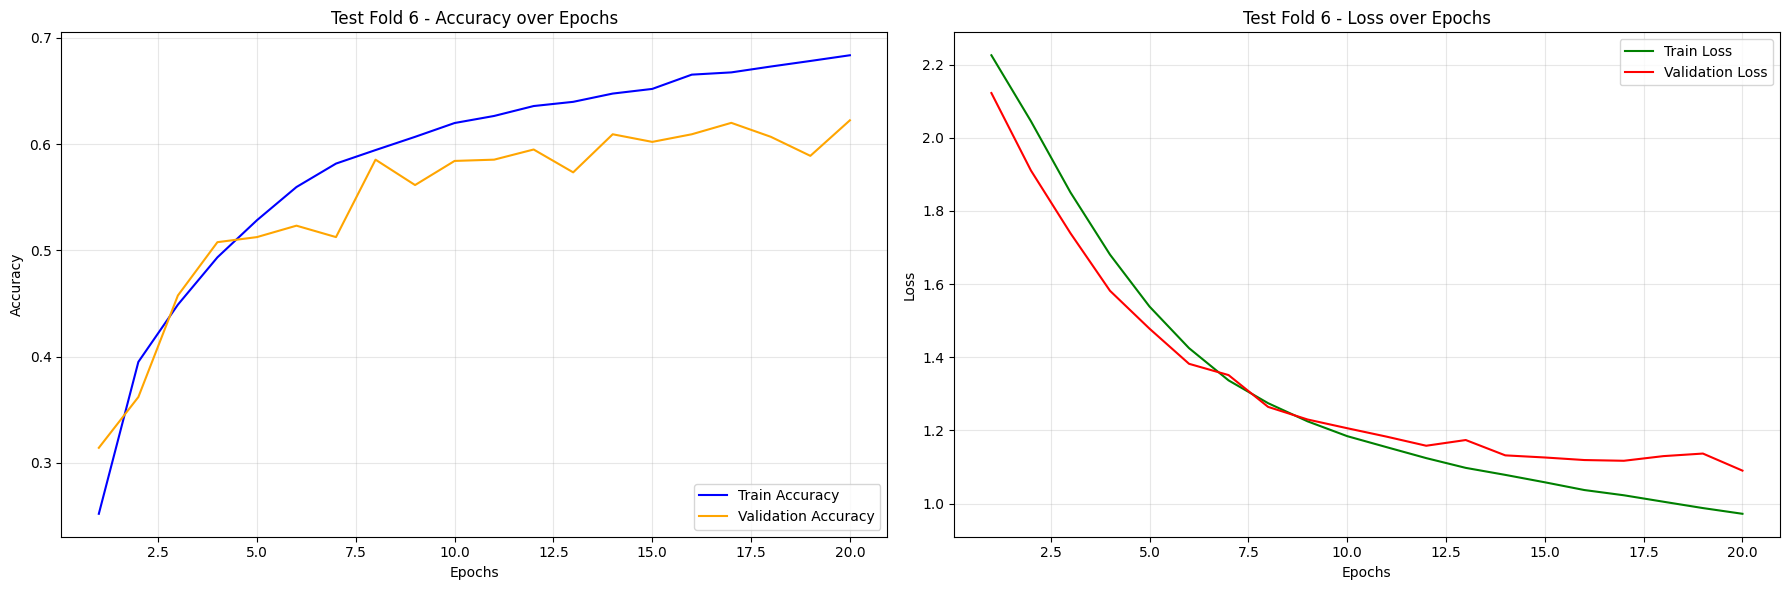

Analyzing Test Fold 7
Test Fold: 7, Validation Fold: 1 -> Accuracy: 0.6987
Test Fold: 7, Validation Fold: 2 -> Accuracy: 0.5214
Test Fold: 7, Validation Fold: 3 -> Accuracy: 0.5611
Test Fold: 7, Validation Fold: 4 -> Accuracy: 0.5960
Test Fold: 7, Validation Fold: 5 -> Accuracy: 0.6389
Test Fold: 7, Validation Fold: 6 -> Accuracy: 0.5128
Test Fold: 7, Validation Fold: 8 -> Accuracy: 0.6377
Test Fold: 7, Validation Fold: 9 -> Accuracy: 0.5944
Test Fold: 7, Validation Fold: 10 -> Accuracy: 0.6260
fold 7 Mean Accuracy: 0.5985, fold 7 Std Dev: 0.0565


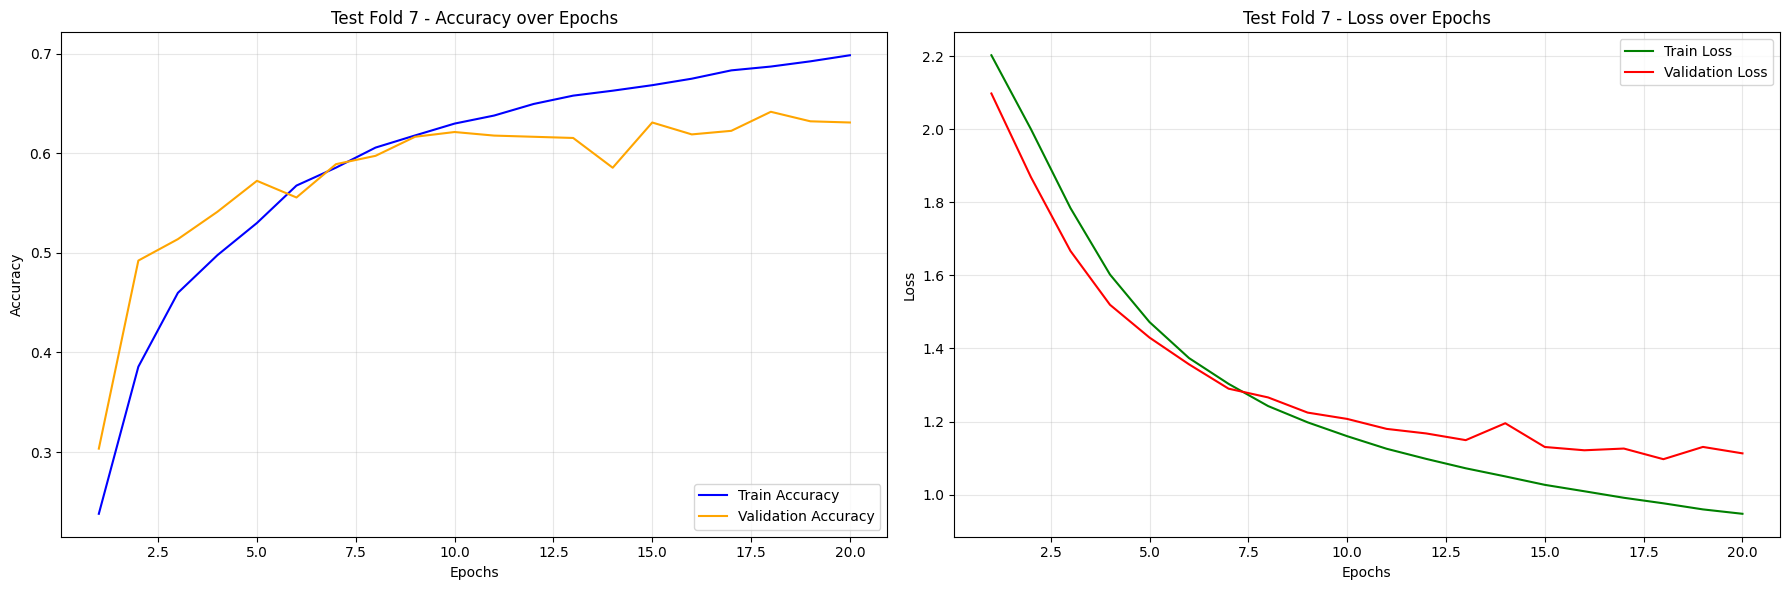

Analyzing Test Fold 8
Test Fold: 8, Validation Fold: 1 -> Accuracy: 0.6804
Test Fold: 8, Validation Fold: 2 -> Accuracy: 0.5484
Test Fold: 8, Validation Fold: 3 -> Accuracy: 0.6173
Test Fold: 8, Validation Fold: 4 -> Accuracy: 0.5657
Test Fold: 8, Validation Fold: 5 -> Accuracy: 0.6058
Test Fold: 8, Validation Fold: 6 -> Accuracy: 0.4994
Test Fold: 8, Validation Fold: 7 -> Accuracy: 0.5370
Test Fold: 8, Validation Fold: 9 -> Accuracy: 0.5797
Test Fold: 8, Validation Fold: 10 -> Accuracy: 0.6272
fold 8 Mean Accuracy: 0.5845, fold 8 Std Dev: 0.0514


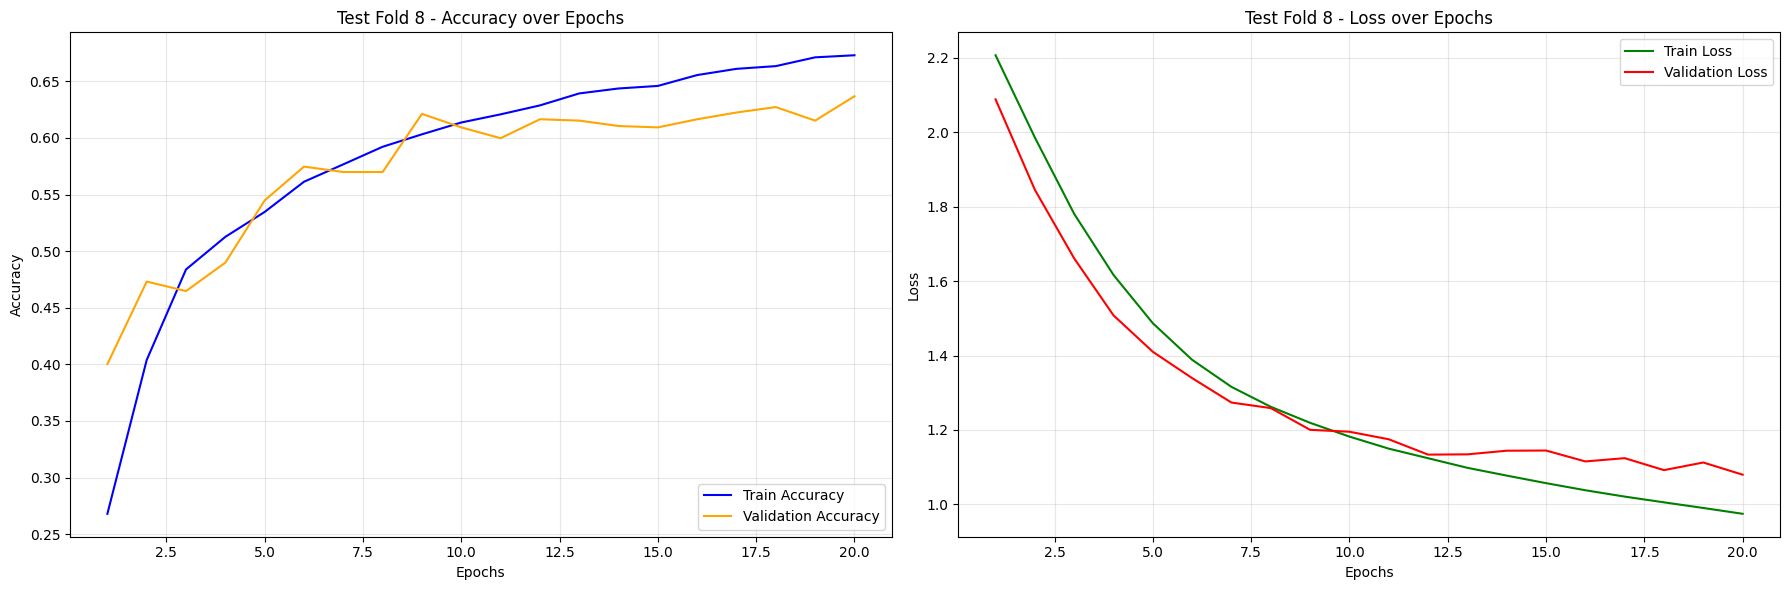

Analyzing Test Fold 9
Test Fold: 9, Validation Fold: 1 -> Accuracy: 0.6449
Test Fold: 9, Validation Fold: 2 -> Accuracy: 0.5529
Test Fold: 9, Validation Fold: 3 -> Accuracy: 0.5946
Test Fold: 9, Validation Fold: 4 -> Accuracy: 0.6202
Test Fold: 9, Validation Fold: 5 -> Accuracy: 0.5929
Test Fold: 9, Validation Fold: 6 -> Accuracy: 0.5662
Test Fold: 9, Validation Fold: 7 -> Accuracy: 0.5668
Test Fold: 9, Validation Fold: 8 -> Accuracy: 0.6253
Test Fold: 9, Validation Fold: 10 -> Accuracy: 0.6141
fold 9 Mean Accuracy: 0.5976, fold 9 Std Dev: 0.0293


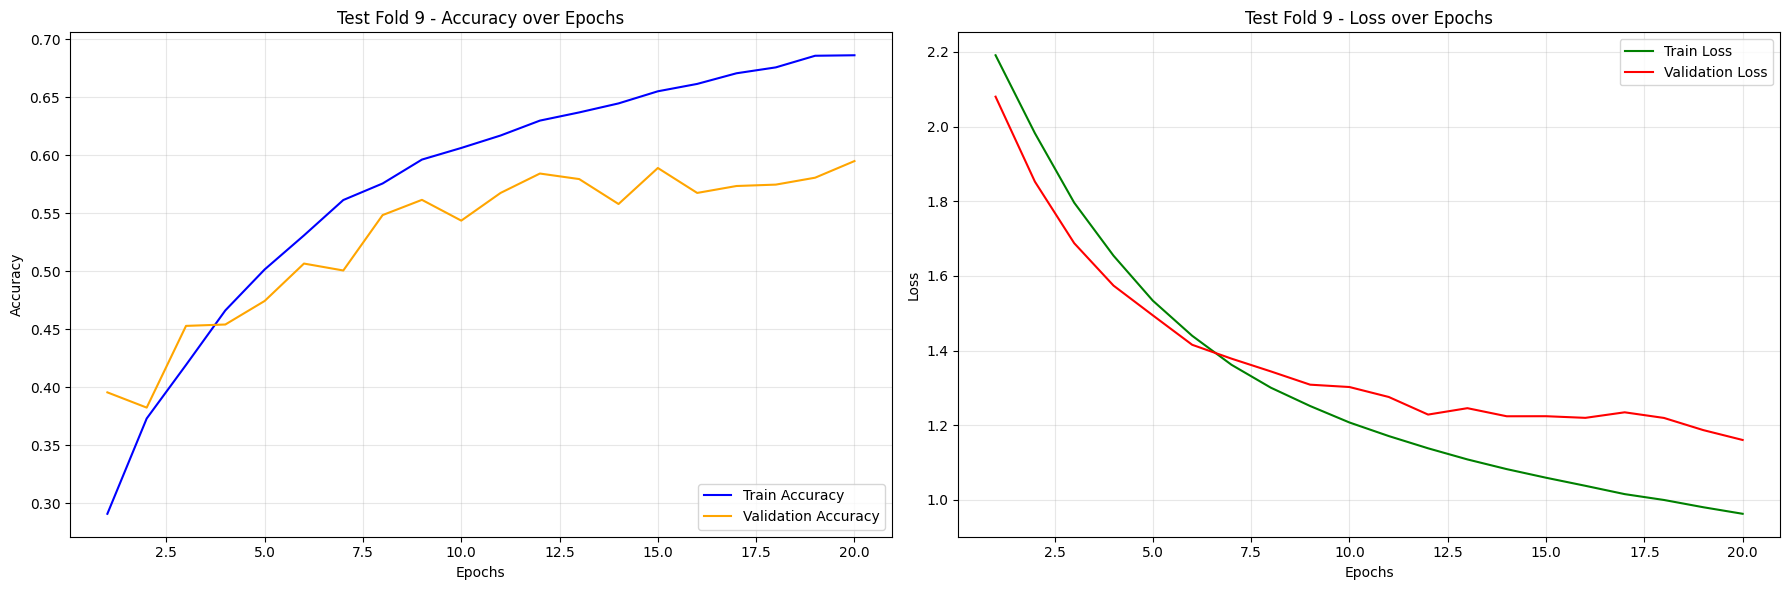

Analyzing Test Fold 10
Test Fold: 10, Validation Fold: 1 -> Accuracy: 0.6586
Test Fold: 10, Validation Fold: 2 -> Accuracy: 0.5574
Test Fold: 10, Validation Fold: 3 -> Accuracy: 0.6032
Test Fold: 10, Validation Fold: 4 -> Accuracy: 0.5960
Test Fold: 10, Validation Fold: 5 -> Accuracy: 0.6517
Test Fold: 10, Validation Fold: 6 -> Accuracy: 0.5383
Test Fold: 10, Validation Fold: 7 -> Accuracy: 0.5716
Test Fold: 10, Validation Fold: 8 -> Accuracy: 0.6315
Test Fold: 10, Validation Fold: 9 -> Accuracy: 0.5355
fold 10 Mean Accuracy: 0.5938, fold 10 Std Dev: 0.0439


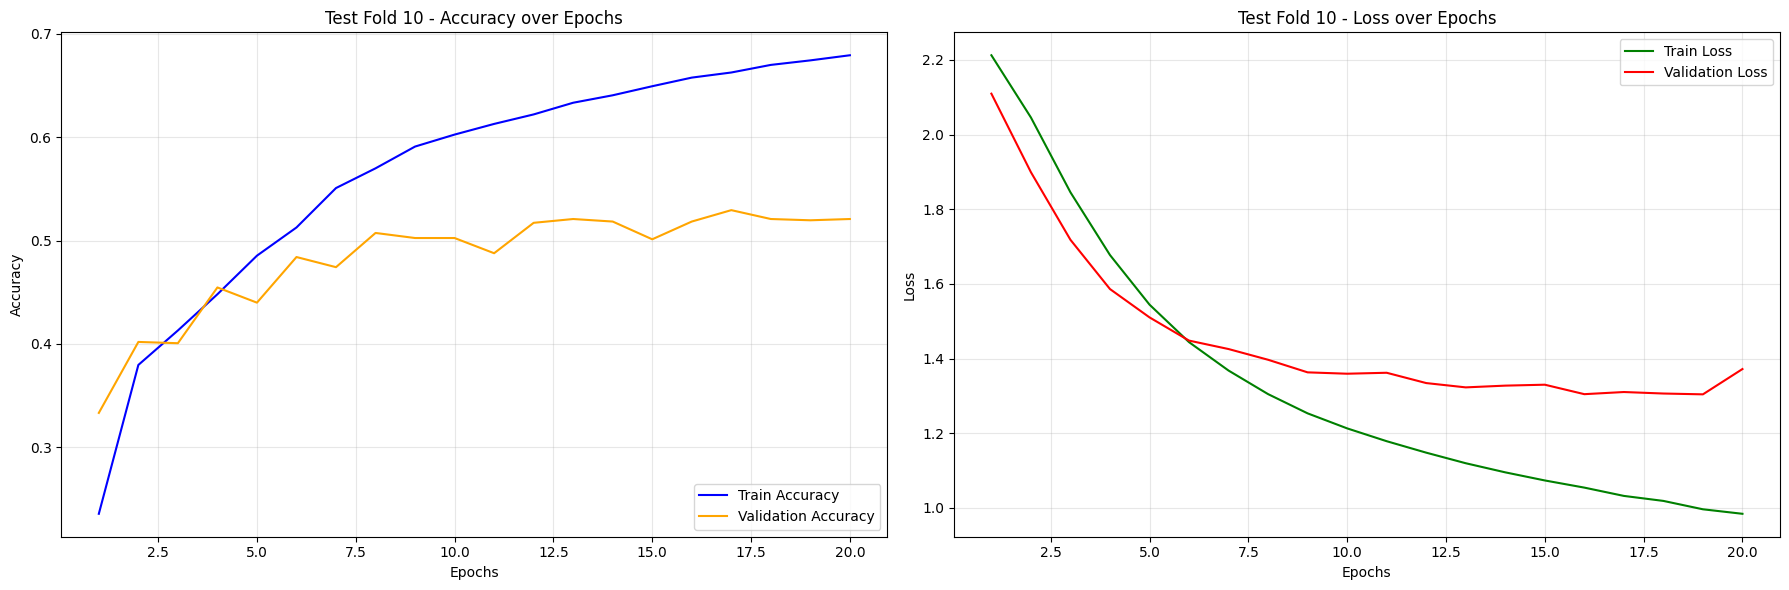

Final Mean Accuracy: 0.5892, Final Std Dev: 0.0444


[(1, 2, <keras.src.callbacks.history.History at 0x30637d910>),
 (1, 3, <keras.src.callbacks.history.History at 0x370b379d0>),
 (1, 4, <keras.src.callbacks.history.History at 0x36efe1b50>),
 (1, 5, <keras.src.callbacks.history.History at 0x36f0265e0>),
 (1, 6, <keras.src.callbacks.history.History at 0x36c9a0a90>),
 (1, 7, <keras.src.callbacks.history.History at 0x318df8a00>),
 (1, 8, <keras.src.callbacks.history.History at 0x34d5374c0>),
 (1, 9, <keras.src.callbacks.history.History at 0x316a24d30>),
 (1, 10, <keras.src.callbacks.history.History at 0x376ad4280>),
 (2, 1, <keras.src.callbacks.history.History at 0x314d42a90>),
 (2, 3, <keras.src.callbacks.history.History at 0x34c66dee0>),
 (2, 4, <keras.src.callbacks.history.History at 0x317f0f280>),
 (2, 5, <keras.src.callbacks.history.History at 0x373cc2a30>),
 (2, 6, <keras.src.callbacks.history.History at 0x3798bdca0>),
 (2, 7, <keras.src.callbacks.history.History at 0x31a609a00>),
 (2, 8, <keras.src.callbacks.history.History at 0x37dd

In [20]:
# Função principal para rodar a validação cruzada e plotar os gráficos para cada fold de teste
files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]

cross_validate_with_test_and_plot(files, files, best_config)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


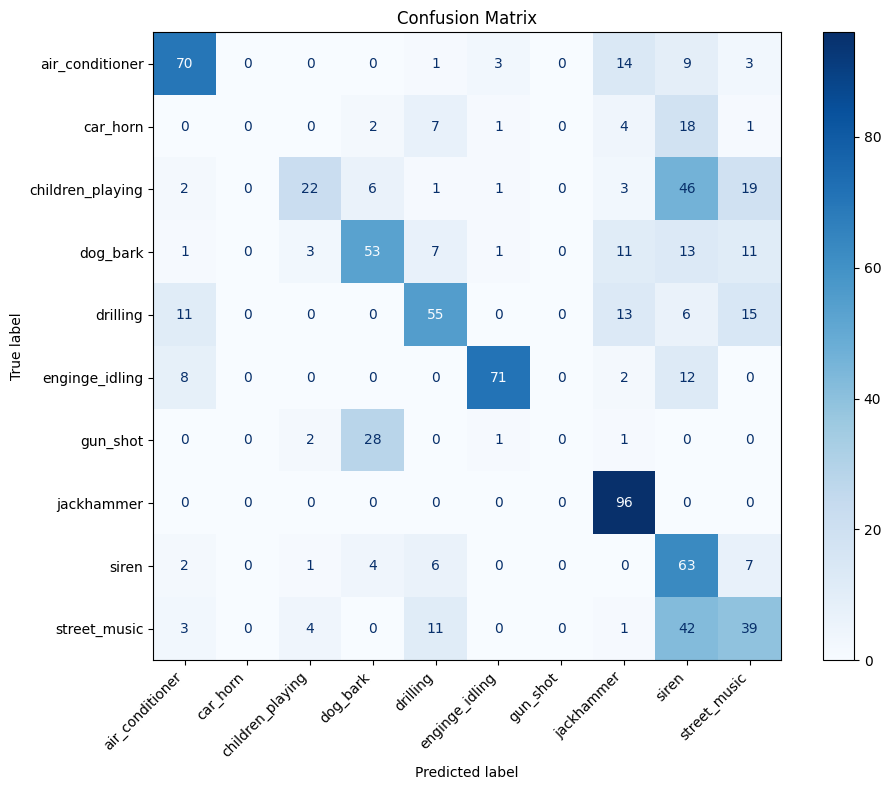

Classification Report:
                   precision    recall  f1-score   support

 air_conditioner       0.72      0.70      0.71       100
        car_horn       0.00      0.00      0.00        33
children_playing       0.69      0.22      0.33       100
        dog_bark       0.57      0.53      0.55       100
        drilling       0.62      0.55      0.59       100
  enginge_idling       0.91      0.76      0.83        93
        gun_shot       0.00      0.00      0.00        32
      jackhammer       0.66      1.00      0.80        96
           siren       0.30      0.76      0.43        83
    street_music       0.41      0.39      0.40       100

        accuracy                           0.56       837
       macro avg       0.49      0.49      0.46       837
    weighted avg       0.57      0.56      0.53       837



/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

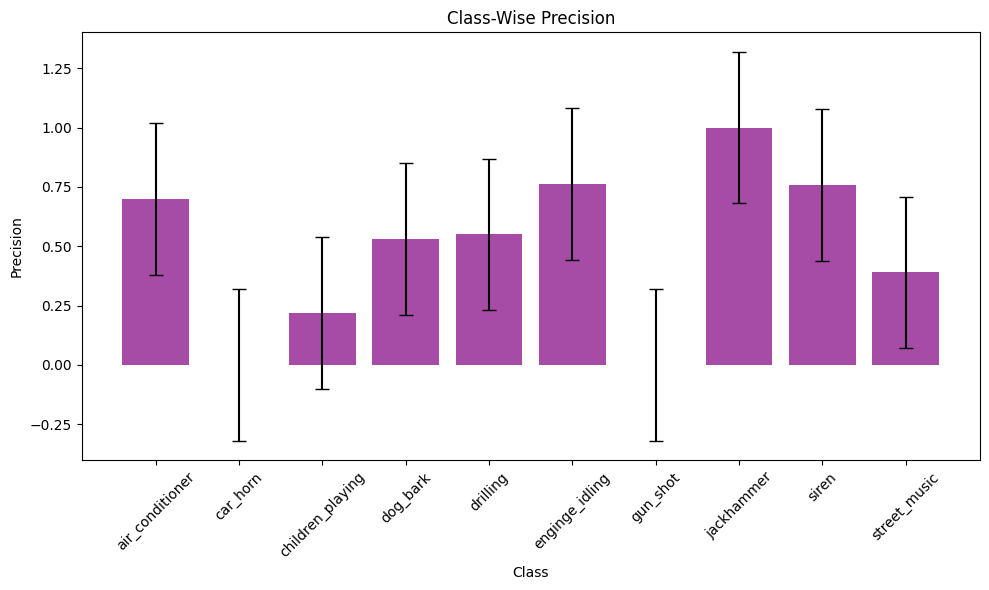

In [ ]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

def generate_confusion_matrix_and_plot(config, X_test, y_test, class_names):
    model = MLP(
        input_dim=X_test.shape[1],
        output_dim=10,
        hidden_units=config['hidden_units'],
        dropout_rate=config['dropout_rate'],
        activations=config['activations'],
        regularization_type=config.get('regularization_type', None),
        regularization_value=config.get('regularization_value', 0.01)
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    # Treinando o modelo
    model.fit(X_test, y_test, batch_size=config['batch_size'], epochs=config['epochs'], verbose=0)
    
    # Fazendo previsões
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Gerando a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Exibindo a matriz de confusão com rótulos ajustados
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))  # Definindo o tamanho da figura
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45, ha="right")  # Rotacionando os rótulos no eixo X para evitar sobreposição
    plt.yticks(rotation=0)  # Mantendo os rótulos no eixo Y horizontais
    plt.tight_layout()  # Ajustando o layout para evitar cortes
    plt.show()

    # Relatório de classificação
    report = classification_report(y_test, y_pred, target_names=class_names)
    print("Classification Report:\n", report)
    
    # Calculando a precisão por classe
    class_precision = cm.diagonal() / cm.sum(axis=1)
    
    # Calculando a média e desvio padrão da precisão por classe
    class_mean_precision = class_precision.mean()
    class_std_precision = class_precision.std()
    
    # Plotando a precisão por classe com erro padrão
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(class_names)), class_precision, yerr=class_std_precision, capsize=5, alpha=0.7, color='purple')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.ylabel('Precision')
    plt.xlabel('Class')
    plt.title('Class-Wise Precision')
    plt.tight_layout()
    plt.show()

# Já definida configuração
best_config = {
    'hidden_units': [256, 128, 64],
    'activations': ['relu', 'relu', 'relu'],
    'dropout_rate': 0.3,
    'batch_size': 64,
    'epochs': 20,
    'learning_rate': 0.0001,
    'regularization_type': None,
    'regularization_value': 0.01
}

# Caminho para os arquivos de dados
files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]

# Carregar dados de teste (ajustar índice conforme necessário)
X_test, y_test = load_fold_data(0, files)

# Definir os nomes das classes
class_names = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark", 
    "drilling", "enginge_idling", "gun_shot", "jackhammer", 
    "siren", "street_music"
]

# Gerar e exibir a matriz de confusão, relatório de classificação e gráfico de precisão por classe
generate_confusion_matrix_and_plot(best_config, X_test, y_test, class_names)
